# Redistricting Lab

**Objectives**
 - Introduce students to congressional redistricting and gerrymandering
 - Introduce students to a new integer programming formulation
 - Expose students to measures of compactness and the efficiency gap
 - Give students experience creating congressional districts for differet objectives

**Reading:** This lab is based on real congressional redistricting research done by Wes Gurnee and David Shmoys. More information about this research can be found at [fairmandering.org](https://www.fairmandering.org). A more complete description of the algorithm can be found [here](https://www.fairmandering.org/algorithm.html).

**Brief description:** In this lab, we will consider a section of a new paper on congressional redistricting. After summarizing the problem of congressional redistricting, we will give a breif overview of the the paper leading up to the relevant section. We will then formulate an integer program to redistrict optimally. Lastly, we will explore possible districts for the state of Georgia subject to various objectives.

<font color='blue'> <b>Solutions are shown blue.</b> </font> <br>
<font color='red'> <b>Instuctor comments are shown in red.</b> </font>

In [1]:
# imports -- don't forget to run this cell!
from redistricting import *
from ortools.linear_solver import pywraplp as OR
%matplotlib inline

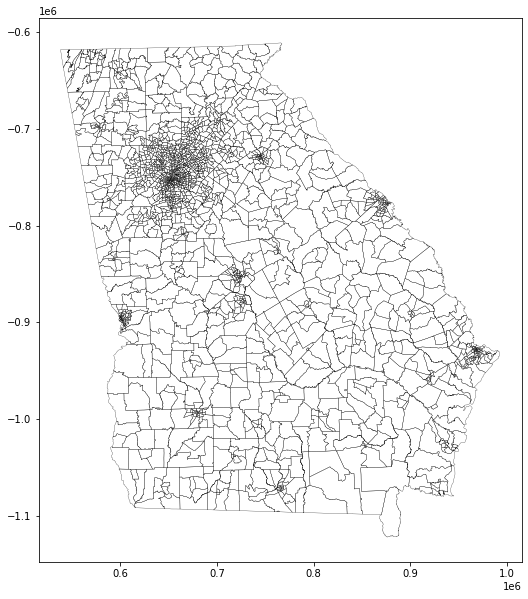

In [2]:
# Load census tract shapes and plot them
tracts = load_tract_shapes()
tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25);

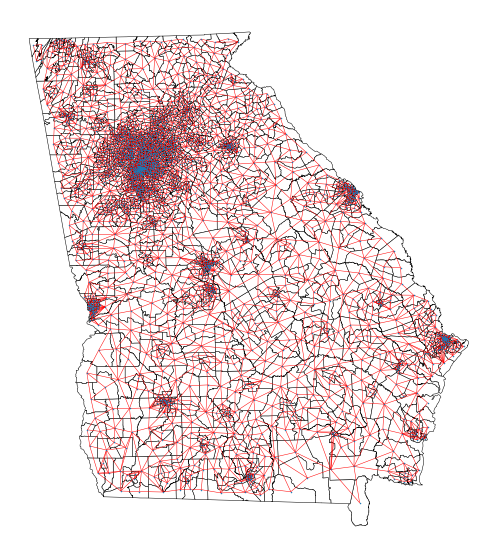

In [3]:
# Load census tracts with adjacency graph overlay
adjacency_graph = load_graph()
draw_adjacency_graph(tracts, adjacency_graph, figsize=(10, 10));

In [4]:
# Load tract statistics and past election results
tract_stats = load_state_df()
display(tract_stats.head())
tract_results = load_election_df()
display(tract_results.head())

,GEOID,x,y,area,population,p_public_transportation_commute,p_walk_commute,mean_commute_time,p_bachelors_degree_or_higher,unemployment_rate,...,p_age_students,median_age,p_mobile_homes,p_without_person_vehicle,p_veterans,2000,2004,2008,2012,2016
0,13001950100,858073.274928,-954008.270831,332.577797,3011,0.0,1.9,20.6,13.7,7.1,...,10.4,42.4,36.4,6.0,9.0,0.653075,0.708609,0.73366,0.748534,0.793014
1,13001950200,854327.007094,-961700.604998,157.961971,4301,1.5,2.0,21.6,11.0,1.6,...,15.5,38.7,39.8,11.8,8.9,0.653075,0.708609,0.73366,0.748534,0.793014
2,13001950300,848608.690803,-967396.534007,72.030374,5609,0.0,0.8,22.9,5.2,8.7,...,7.1,36.8,26.3,13.5,7.5,0.653075,0.708609,0.73366,0.748534,0.793014
3,13001950400,866679.762897,-977255.292313,389.608817,1669,0.0,0.0,30.2,9.8,6.9,...,17.0,44.4,34.8,5.9,5.0,0.653075,0.708609,0.73366,0.748534,0.793014
4,13001950500,848558.128112,-974848.057797,375.617826,3864,0.0,1.2,22.9,11.7,5.3,...,18.3,38.0,48.7,3.3,6.2,0.653075,0.708609,0.73366,0.748534,0.793014


,D_pres_2016,D_senate_2016,R_pres_2016,R_senate_2016,D_gov_2018,D_AG_2018,R_gov_2018,R_AG_2018,D_pres_2008,R_pres_2008,D_pres_2012,R_pres_2012
0,118.976380,113.833984,1228.740713,1138.656102,98.336016,120.571006,1220.973312,1162.348625,198.956156,1148.760937,178.910936,1168.806157
1,735.846511,585.415804,826.726385,810.174598,746.404700,705.957397,776.081801,751.312270,828.576826,733.996070,805.335956,757.236940
2,142.722300,112.224541,618.825657,585.135149,111.532707,115.983323,456.481014,428.724465,187.916084,573.631873,176.589229,584.958729
3,210.333782,171.992717,970.651386,922.888445,198.123861,205.243347,1143.934378,1096.275617,280.418913,900.566255,262.853574,918.131594
4,226.039033,203.460763,1848.445280,1712.578804,203.602699,236.244910,1830.529356,1739.338889,349.148543,1725.335770,318.293778,1756.190535


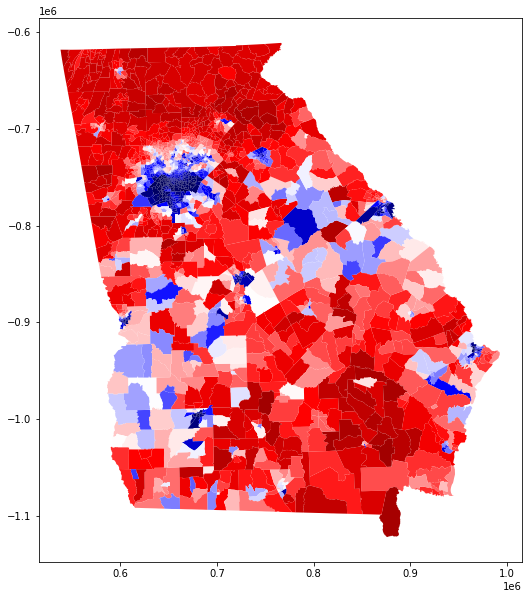

In [5]:
# Plot 2016 election results
tracts['2016_pres'] = tract_results.apply(lambda x: x.R_pres_2016 / (x.R_pres_2016 + x.D_pres_2016), axis=1)
tracts.plot(column='2016_pres', cmap='seismic', vmin=0, vmax=1, figsize=(15, 10));

In [6]:
# Load leaf and internal nodes from sample tree
leaf_nodes = pickle.load(open('data/leaf_nodes.p', 'rb'))
internal_nodes = pickle.load(open('data/internal_nodes.p', 'rb'))

In [7]:
# Load tract statistics aggregated to district level
district_df = pd.read_csv(os.path.join('data', 'ga_district_df.csv'))
display(district_df.head())

,GEOID,x,y,area,population,p_public_transportation_commute,p_walk_commute,mean_commute_time,p_bachelors_degree_or_higher,unemployment_rate,...,R_pres_2008,D_pres_2012,R_pres_2012,mean,std_dev,DoF,dispersion,roeck,edge_ratio,cut_edges
0,1.314602e+10,703256.530393,-683238.278815,11620.575332,741282.0,0.263438,1.060602,28.708458,24.660949,4.415160,...,228413.902725,54878.667195,238264.578182,0.799446,0.015679,5,33.760417,0.689454,2.559441,79
1,1.315523e+10,593515.520895,-670198.460670,12074.251776,729379.0,0.330174,1.331401,26.312435,17.059684,5.861012,...,189279.013056,61557.904496,196644.896626,0.778598,0.026533,5,41.635791,0.541537,2.581395,39
2,1.315163e+10,598063.232258,-665663.233476,11614.689714,728249.0,0.349841,1.366476,26.185927,17.888402,5.887867,...,188677.384757,60598.859065,196301.469223,0.778885,0.025600,5,39.888216,0.627797,2.585938,36
3,1.314296e+10,707134.463222,-688229.849150,10146.377476,734472.0,0.309298,1.039873,29.025757,25.267252,4.267012,...,222458.642775,56088.784870,231149.162240,0.788368,0.016061,5,31.086731,0.908944,2.610294,71
4,1.310710e+10,621078.264937,-738691.322260,2955.850099,742702.0,0.962230,0.766883,34.362520,30.987041,5.725069,...,170725.815890,117931.610853,175607.309792,0.559761,0.036215,5,16.856137,0.712542,2.509804,71


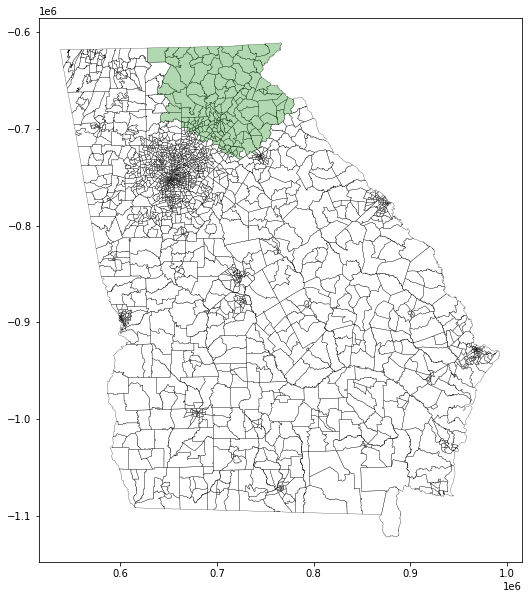

In [8]:
# Highlight the region corresponding to some node of the sample tree
ax = tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25) 
tracts.iloc[leaf_nodes[0]['area']].plot(ax=ax, color='green', alpha=.3);

In [9]:
def redistrict(k, tract_district_matrix, cost, integer=False, opt_type='abs_val', solver='CBC'):
    """A model for solving a congressional redistricting problem.
    
    Args:
        k (int): number of districts in a plan
        tract_district_matrix (np.ndarray): binary matrix a_ij = 1 if tract i is in district j
        costs (np.ndarray): cost coefficients of districts
        opt_type (str): {"minimize", "maximize", "abs_val"}
        solver (str) : {"CBC", "gurobi"}
    """
    n_tracts, n_columns = tract_district_matrix.shape
    TRACTS = range(n_tracts)
    DISTRICTS = range(n_columns)
    
    # define the model
    if solver=='CBC':
        m = OR.Solver('redistrict', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)        
    elif solver=='gurobi':
        m = OR.Solver('redistrict', OR.Solver.GUROBI_MIXED_INTEGER_PROGRAMMING)
    else:
        raise ValueError('Invalid solver')

    # decision variables
    x = {} # x_i is 1 if district i is used, 0 otherwise
    for d in DISTRICTS:
        if integer:
            x[d] = m.IntVar(0, 1, name="x(%s)" % d)
        else:
            x[d] = m.NumVar(0, 1, name="x(%s)" % d)

    # objective function
    if opt_type == 'minimize':
        m.Minimize(sum(cost[d] * x[d] for d in DISTRICTS))
    elif opt_type == 'maximize':
        m.Maximize(sum(cost[d] * x[d] for d in DISTRICTS))
    elif opt_type == 'abs_val':
        w = m.NumVar(-k, k, name="w")
        m.Add(sum(cost[d] * x[d] for d in DISTRICTS) <= w, name='absval_pos')
        m.Add(sum(cost[d] * x[d] for d in DISTRICTS) >= -w, name='absval_neg')
        m.Minimize(w)
    else:
        raise ValueError('Invalid optimization type')

    # subject to: each census tract appears in exactly one district
    for t in TRACTS:    
        m.Add(sum(x[d] * tract_district_matrix[t,d] for d in DISTRICTS) == 1)

    # subject to: k total districts
    m.Add(sum(x[d] for d in DISTRICTS) == k)

    return m,x

In [10]:
def solve(m, solver='CBC'):
    """Solve the model and specify some solver parameters."""
    if solver=='CBC':
        m.SetTimeLimit(int(len(leaf_nodes) / 10))
        params = OR.MPSolverParameters()
        params.SetDoubleParam(params.RELATIVE_MIP_GAP, 1e-4)
        status = m.Solve(params)
    elif solver=='gurobi':
        params_set = m.SetSolverSpecificParametersAsString(
                     '''TimeLimit %d
                        MIPGapAbs %d''' % ((len(leaf_nodes) / 10), 1e-4))
        if params_set:
            print('Gurobi solver parameters set successfully.')
        status = m.Solve()
        if status == OR.Solver.OPTIMAL:
            print('Optimal solution found.')
            print('Objective value =', m.Objective().Value())
        else:
            print('Optimal solution was not found.')

In [11]:
# Generate inputs for the redistricting model
n_districts = 14
tract_district_matrix = make_tdm(leaf_nodes, len(tracts))
cost = efficiency_gap_coefficients(district_df, .53)
partition_map = make_root_partition_to_leaf_map(leaf_nodes, internal_nodes)

In [12]:
# Solve each root partition / shard
sol_dict = {}
for partition_ix, leaf_slice in partition_map.items():
    m,x = redistrict(k=n_districts,
                     tract_district_matrix=tract_district_matrix[:, leaf_slice],
                     cost=cost[leaf_slice],
                     integer=True,
                     solver='gurobi')
    solve(m, solver='gurobi')
    opt_cols = [j for j, v in x.items() if v.solution_value() > .5]
    sol_dict[partition_ix] = {'n_leaves': len(leaf_slice),
                              'solution_ixs': partition_map[partition_ix][opt_cols],
                              'optimal_objective': cost[leaf_slice][opt_cols]}
    if partition_ix == 0:
        break # Stopping after 1 root partition / shard

Gurobi solver parameters set successfully.
Optimal solution found.
Objective value = 0.35507308632008094


In [13]:
# Arbitrarily choose the root partition / shard with the best objective value 
obj_vals = np.array([sol_dict[ix]['optimal_objective'].sum() for ix in sol_dict])
best_solution = sol_dict[np.argmin(obj_vals)]

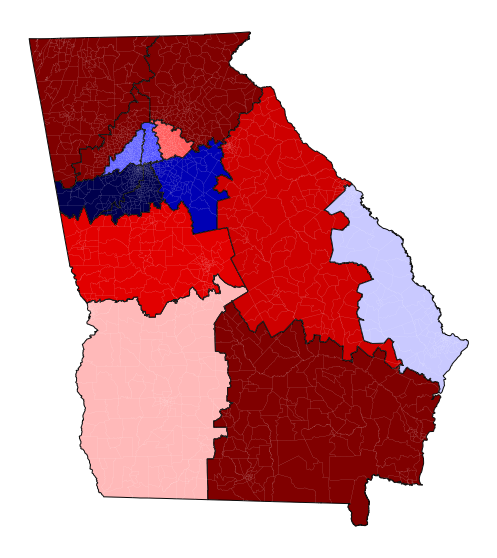

In [14]:
# Plot the districts of the best solution
politics_map(tracts, district_df, leaf_nodes, best_solution);